Import packages and include helper functions for the unscented Kalman filter. The UKF code is inspired by the code in [Chapter 19](/https://algorithmsbook.com/files/chapter-19.pdf) of *Kochenderfer, M. J., 
Wheeler, T. A., & Wray, K. H. (2022). Algorithms for Decision Making. MIT Press.*

In [1]:
using Distributions
using LinearAlgebra
using PGFPlots
using Random
using StatsBase

include("ukf.jl")

update (generic function with 1 method)

In this example we model the motion of a nonholonomic robot that moves according to the kinematic bicycle model. The state variables are the robot's position and heading angle and the control inputs are the velocity $v$ and steering angle $\phi$. Perfect equations of motion are as follows:

\begin{align*}
    p^x_{t+1} &= \Delta t \cdot v \cdot \cos(\theta_t)\\
    p^y_{t+1} &= \Delta t \cdot v \cdot \sin(\theta_t)\\
    \theta_{t+1} &= \Delta t \cdot v \cdot \tan(\phi)/L
\end{align*}

Measurements come in the form of noisy GPS measurements. The noise-free measurement equation is given by

\begin{align*}
    y_t &= (p^x_t, p^y_t)
\end{align*}

In [2]:
# Transition model
function f(x, u)
    v, ϕ = u    # Unpack actions
    Δt = 0.1    # Time step
    L= 2.8      # Bicycle model wheel base [m]
    x′ = x + Δt*([v*cos(x[3]); v*sin(x[3]); v*tan(ϕ)/L])
    return x′
end

# Measurement model
function h(x, u)
    y = [x[1], x[2]]
    return y
end

# Function to run T steps of a simulation starting at state x0 and using the
# transition model f and measurement model h specified by the filter
function simulate(ukf, x0, T, actions)   
    Q, R, f, h = ukf.Q, ukf.R, ukf.f, ukf.h
    nx = first(size(Q)) # Dimensionality of each state
    ny = first(size(R)) # Dimensionality of each observation
    states =[x0]; observations = [fill(NaN, ny)]
    for t = 2:T
        push!(states, 
            f(states[t-1], actions[t]) + rand(MvNormal(zeros(nx), Q)))
        push!(observations, 
            h(states[t], actions[t]) + rand(MvNormal(zeros(ny), R)))
    end
    return states, observations
end

simulate (generic function with 1 method)

Initialize simulation variables:

In [4]:
T   = 10            # Simulation length
N   = 50            # Number of particles
Δt  = 0.1           # Time step
times = 0:Δt:T      # Simulation times
actions = [[6.0, 0.5*cos(0.5*t)] for t in times]    # Action sequence

# Noise statistics
Q   = Δt*0.05*Matrix{Float64}(I,3,3)
R   = 0.1*Matrix{Float64}(I,2,2)

ukf = UnscentedKalmanFilter(2, Q, R, f, h) # Unscented particle filter

x0  = [0.0; 0.0; 0.0]
x   = fill(x0, N)   # Initial particle set values
P0  = 0.01*Matrix{Float64}(I,3,3)
P   = fill(P0, N)   # Initial particle set covariances

x̂   = fill(x0, N)   # Data structure to hold sampled particles
x̄   = fill(x0, N)   # Data structure to hold posterior means
P̂   = fill(P0, N)   # Data structure to hold posterior covariances

μ_data  = [mean(x)] # Vector to hold mean data for plotting
Σ_data  = [cov(x)]  # Vector to hold covariance data for plotting

# Generate simulated data
states, observations = simulate(ukf, x0, lastindex(times), actions);

Run the unscented particle filter:

In [5]:
for t = 2:lastindex(times)
    Q, R = ukf.Q, ukf.R # Noise statistics
    y = observations[t] # Latest observation     
    for i = 1:N
        # Perform a belief update
        x̄[i], P̂[i] = update(ukf, x[i], P[i], y, actions[t])
        # Draw a new particle from the proposal distribution
        x̂[i] = rand(MvNormal(x̄[i], Hermitian(P̂[i])))
    end

    # Evaluate importance weights up to a normalizing constant
    w = ones(N)/N;
    for i = 1:N
        ŷ = h(x̂[i], actions[t])  # Predicted measurement

        # Compute observation likelihood
        likelihood = pdf(MvNormal(ŷ, R), y)
        # Calculate prior
        prior = pdf(MvNormal(x[i], Q), x̂[i])
        # Calculate proposal
        proposal = pdf(MvNormal(x̄[i], Hermitian(P̂[i])), x̂[i])
        
        # Compute the particle weight
        w[i] = likelihood * prior / proposal
    end
    # Normalize weights
    w = w/sum(w)

    # Resample particles
    resampled_idx = sample(1:N, Weights(w), N, replace=true)
    x = x̂[resampled_idx]
    P = P[resampled_idx]

    # Store plotting data
    push!(μ_data, mean(x)); push!(Σ_data, cov(x))
end

Plot the resulting estimate of the true state:

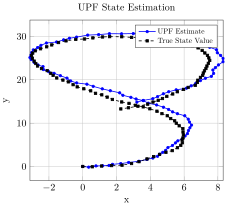

In [8]:
true_x = [s[1] for s in states]; true_y = [s[2] for s in states]
μx = [μ[1] for μ in μ_data]; μy = [μ[2] for μ in μ_data]

p = Axis([
    Plots.Linear(μx, μy, legendentry="UPF Estimate",
        style="blue, thick, mark options={scale=0.6, fill=blue, solid}"), 
    Plots.Linear(true_x, true_y, legendentry="True State Value",
        style="black, dashed, thick, mark options={scale=0.6,fill=black,solid}"),
],
style="enlarge x limits=false,grid=both", ylabel="y", xlabel="x",
title="UPF State Estimation", legendPos="north east",
legendStyle="nodes = {scale = 0.75}")